# **Object Detection with Detectron 2 using a Custom Dataset**

**Detectron2** is a research platform and a production library for object detection, built by **Facebook AI Research (FAIR)**.

It is completely written on PyTorch and is flexible and extensible, and able to provide fast training on single or multiple GPU servers. 

Also, it includes high-quality implementations of state-of-the-art object detection algorithms, including 
**DensePose**
, 
**panoptic feature pyramid network**s
, and numerous variants of the pioneering 
**Mask R-CNN**
model family also developed by FAIR. 

Its extensible design makes it easy to implement cutting-edge research projects without having to fork the entire codebase.


**In this notebook, we are going to deal with identifying the language of text using the Faster RCNN model from the Detectron 2's model zoo.**

We are going to limit our languages by 2.



We identify **Hindi** and **English** Text and we include a Single Class called **Others** for other languages.

Upload it either to your session storage or upload it to your drive and mount your drive to this notebook.





In [ ]:
from google.colab.patches import cv2_imshow
import numpy as np
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#If you did upload the zip file to your session storage, use this command or else modify accordingly.
!ls
!unzip "/content/drive/My Drive/Text_Detection_Dataset_COCO_Format.zip"

drive  sample_data
Archive:  /content/drive/My Drive/Text_Detection_Dataset_COCO_Format.zip
   creating: Text_Detection_Dataset_COCO_Format/
   creating: Text_Detection_Dataset_COCO_Format/train/
  inflating: Text_Detection_Dataset_COCO_Format/train/0.jpeg  
  inflating: Text_Detection_Dataset_COCO_Format/train/1.jpeg  
  inflating: Text_Detection_Dataset_COCO_Format/train/10.jpeg  
  inflating: Text_Detection_Dataset_COCO_Format/train/100.jpeg  
  inflating: Text_Detection_Dataset_COCO_Format/train/101.jpeg  
  inflating: Text_Detection_Dataset_COCO_Format/train/102.jpeg  
  inflating: Text_Detection_Dataset_COCO_Format/train/103.jpeg  
  inflating: Text_Detection_Dataset_COCO_Format/train/104.jpeg  
  inflating: Text_Detection_Dataset_COCO_Format/train/105.jpeg  
  inflating: Text_Detection_Dataset_COCO_Format/train/106.jpeg  
  inflating: Text_Detection_Dataset_COCO_Format/train/107.jpeg  
  inflating: Text_Detection_Dataset_COCO_Format/train/108.jpeg  
  inflating: Text_Detection_D

## **Install Dependencies**

Kickstart with installing a few dependencies such as Torch Vision and COCO API and check whether Cuda is available. Cuda helps in keeping track of the currently selected GPU.

In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8MB 24kB/s 
     |████████████████████████████████| 6.6MB 68.9MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101
     |████████████████████████████████| 276kB 4.5MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=3fe1a66ba5e877bb521b2b5e1ad38f78d3c14f1cd7fdb671ee969ed71b94835f
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip

## **Install Detectron2**

 And then install Detectron2

In [ ]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 660kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20200912-cp36-none-any.whl size=43996 sha256=749fcd13c52c2ea139c88ffd3f9ff5cd14a11487e32c74aa6606ad8474d05168
  Stored in directory: /root/.cache/pip/wheels/34/41/7b/f0a0b5800bea0474ae553342bde52093fdd5852764463aa2ec
Successfully built fvcore


Import a few necessary packages.

In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

## **Preparing and registering the Dataset**



There are different types for the format of bbox. It must be a member of structures.BoxMode.There are 5 such formats. But, currently it supports: **BoxMode.XYXY_ABS, BoxMode.XYWH_ABS**. We use the second format and mention the same in our dataset. After that, we need to register our datset.

In [ ]:
import json
from detectron2.structures import BoxMode
def get_board_dicts(imgdir):
    json_file = imgdir+"/dataset.json"
    with open(json_file) as f:
        dataset_dicts = json.load(f)
    for i in dataset_dicts:
        filename = i["file_name"] 
        i["file_name"] = imgdir+"/"+filename 
        for j in i["annotations"]:
            j["bbox_mode"] = BoxMode.XYWH_ABS
            j["category_id"] = int(j["category_id"])
    return dataset_dicts


from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "val"]:
    DatasetCatalog.register("boardetect_" + d, lambda d=d: get_board_dicts("Text_Detection_Dataset_COCO_Format/" + d))
    MetadataCatalog.get("boardetect_" + d).set(thing_classes=["HINDI","ENGLISH","OTHER"])
board_metadata = MetadataCatalog.get("boardetect_train")

## **Visualizing the Training Dataset**

We'll now try to visualize the training dataset. We'll randomly pick 3 pictures from the train folder of our dataset and see how the bounding boxes look like.

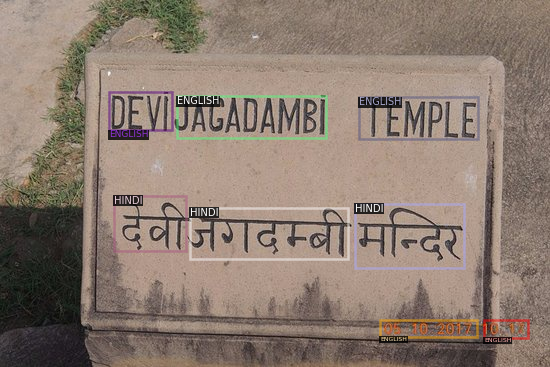

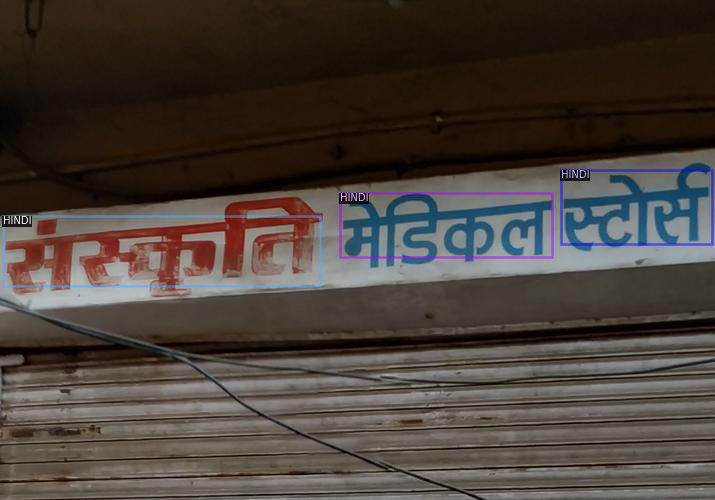

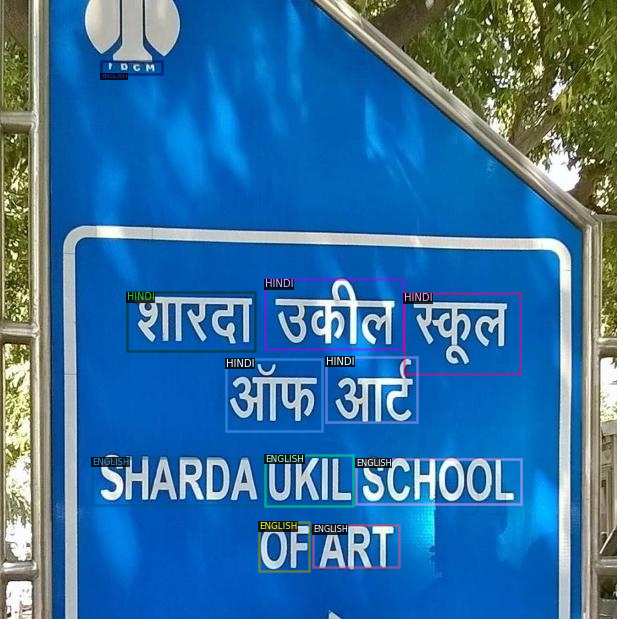

In [ ]:
dataset_dicts = get_board_dicts("Text_Detection_Dataset_COCO_Format/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=board_metadata)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## **Training the Faster R-CNN Model**

In [ ]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

This is the step where we set the configuration for training. Everything related to hyperparameters and parameters related to normalization must be defined here.

We use the **"faster_rcnn_R_50_FPN_3x.yaml"** model from the model zoo of the Detectron2.

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("boardetect_train",)
cfg.DATASETS.TEST = ("boardetect_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0125  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 # No. of classes = [HINDI, ENGLISH, OTHER]
cfg.TEST.EVAL_PERIOD = 500
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[09/15 11:19:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:03, 55.7MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.


[09/15 11:19:56 d2.engine.train_loop]: Starting training from iteration 0
[09/15 11:20:14 d2.utils.events]:  eta: 0:14:29  iter: 19  total_loss: 1.951  loss_cls: 1.079  loss_box_reg: 0.475  loss_rpn_cls: 0.300  loss_rpn_loc: 0.074  time: 0.8812  data_time: 0.0365  lr: 0.000250  max_mem: 4964M
[09/15 11:20:32 d2.utils.events]:  eta: 0:14:20  iter: 39  total_loss: 1.473  loss_cls: 0.565  loss_box_reg: 0.774  loss_rpn_cls: 0.064  loss_rpn_loc: 0.062  time: 0.9041  data_time: 0.0125  lr: 0.000500  max_mem: 4964M
[09/15 11:20:50 d2.utils.events]:  eta: 0:14:00  iter: 59  total_loss: 1.136  loss_cls: 0.394  loss_box_reg: 0.620  loss_rpn_cls: 0.053  loss_rpn_loc: 0.065  time: 0.8988  data_time: 0.0181  lr: 0.000749  max_mem: 4964M
[09/15 11:21:08 d2.utils.events]:  eta: 0:13:52  iter: 79  total_loss: 1.114  loss_cls: 0.384  loss_box_reg: 0.601  loss_rpn_cls: 0.051  loss_rpn_loc: 0.059  time: 0.9034  data_time: 0.0183  lr: 0.000999  max_mem: 4964M
[09/15 11:21:27 d2.utils.events]:  eta: 0:13:4

Using this, you can analyze how your training was progressed over time. 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output

## **Inference from the Validation Dataset using the trained model**

An output folder gets saved in the local storage in which the final weights are stored. You can save this folder for inferencing from this model in future.

Set the score threshold value for reducing the redundant boxes on the prediction results.

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set the testing threshold for this model
cfg.DATASETS.TEST = ("boardetect_val", )
predictor = DefaultPredictor(cfg)

In [ ]:
imgNumber = 1

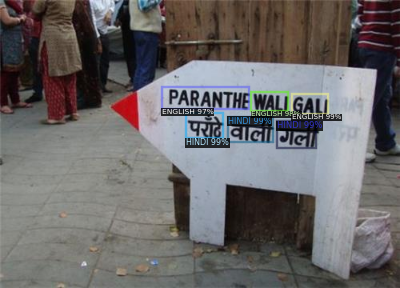

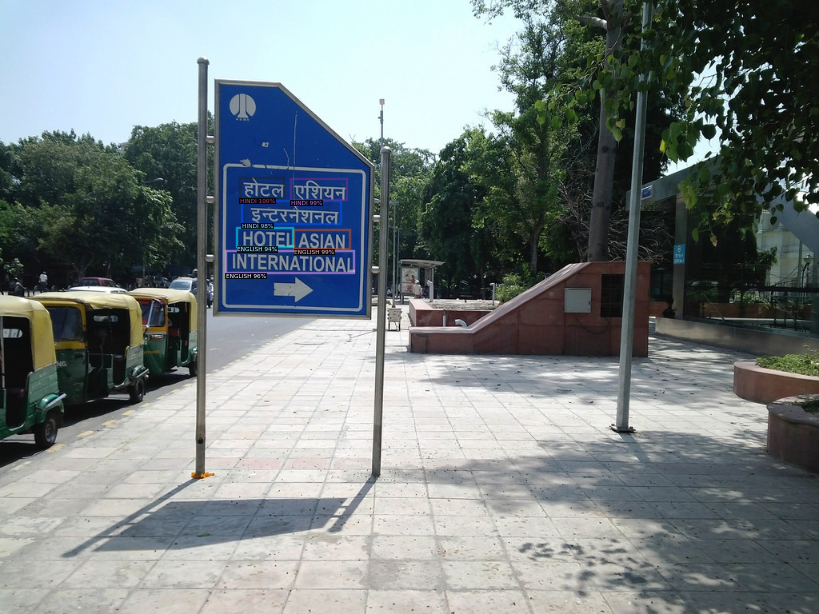

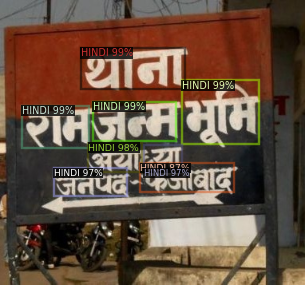

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_board_dicts("/content/Text_Detection_Dataset_COCO_Format/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    images.append(im)
    outputs = predictor(im)
    instanceBoxes = outputs["instances"].pred_boxes.tensor.detach().cpu().numpy()
    instanceBoxClasses = outputs["instances"].pred_classes.tensor.detach().cpu().numpy()
    numberOfBoxes = instanceBoxes.shape[0]
    croppedImages = []
    for i in range(numberOfBoxes):
        y1 = int(instanceBoxes[i][0])
        x1 = int(instanceBoxes[i][1])
        y2 = int(instanceBoxes[i][2])
        x2 = int(instanceBoxes[i][3])
        #if the predicted class is hindi then crop the image and save it
        if (instanceBoxClasses[i]==0):
            cv2.imwrite(str(imgNumber)+".png",im[x1:x2,y1:y2])
        imgNumber += 1
    v = Visualizer(im[:, :, ::-1],
                   metadata=board_metadata, 
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])